# APS1070
#### Project 1 --- Basic Principles and Models
**Deadline: Oct 6th, 11PM - 10 percent**

# Project 1 [10 Marks]
Let's apply the tools we have learned in the tutorial to a new dataset.

We're going to work with a [boston dataset](https://openml.org/search?type=data&status=any&id=43465). Download it using the cell below:

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dataset = fetch_openml(name='Boston-house-price-data', version=1, parser="auto")

## Part 1: Getting started [2.5 Marks]
First off, take a look at the `data`, `target` and `feature_names` entries in the `dataset` dictionary. They contain the information we'll be working with here. Then, create a Pandas DataFrame called `df` containing the data and the targets, with the feature names as column headings. If you need help, see [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for more details on how to achieve this. **[0.4]**
* How many features do we have in this dataset? Ans: 13
* Determine the median target value. Ans: 21.2
* How many participants have a target value greater than the median target value? Ans: 250

Now add an additional column containing either 0 (if the target value is below the median) or 1 (if the target value is above the median). This will be the new target value to classify the data as the owner-occupied homes value in \$1000's below median or the owner-occupied homes value in \$1000's above median. **[0.5]**

In [8]:
df_data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df_target = pd.DataFrame(dataset.target, columns=['MEDV'])

df = pd.concat([df_data, df_target], axis=1)

num_features = len(dataset['feature_names'])
num_features

median_target_value = df['MEDV'].median()
median_target_value

num_homes_above_median = len(df[df['MEDV'] > median_target_value])
num_homes_above_median

df['aboveMEDV'] = [1 if x >= median_target_value else 0 for x in df['MEDV']]

13

### Splitting the data
It is best practice to have a training set (from which there is a rotating validation subset) and a test set. Our aim here is to (eventually) obtain the best accuracy we can on the test set (we'll do all our tuning on the training/validation sets, however.)

**Split the dataset** into a train and a test set **"70:30"**, use **``random_state=0``**. The test set is set aside (untouched) for final evaluation, once hyperparameter optimization is complete. **[0.5]**

**Only Split the dataset once within you notebook.** You should not use the `train_test_split` function more than once, regardless of the random state. Keep this in mind for your future projects as well.

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(['MEDV', 'aboveMEDV'], axis=1)
y = df['aboveMEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Effect of Standardization (Visual)
Use `seaborn.lmplot` ([help here](https://seaborn.pydata.org/generated/seaborn.lmplot.html)) to visualize a few features of the training set. Draw a plot where the x-axis is the *proportion of owner-occupied units built prior to 1940* i.e. ``AGE``, the y-axis is the *weighted distances to five Boston employment centres* i.e. ``DIS``, and the color of each datapoint indicates its class.  **[0.5]**

Standardizing the data is often critical in machine learning. Show a plot as above, but standardize the two features. What's different? **why do they look similar?** Based on your observation, what is the advantage of standardization? **[0.6]**


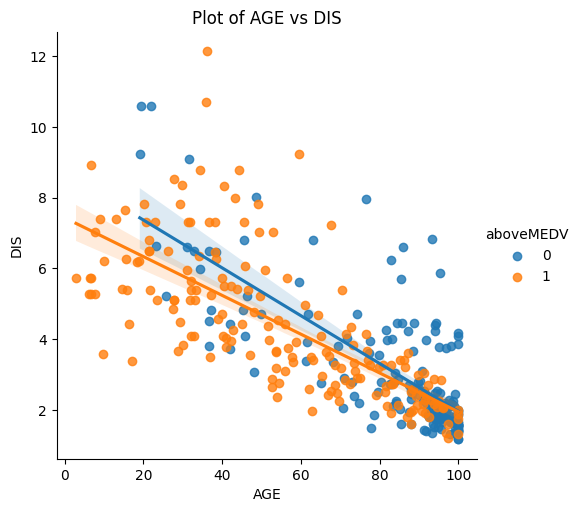

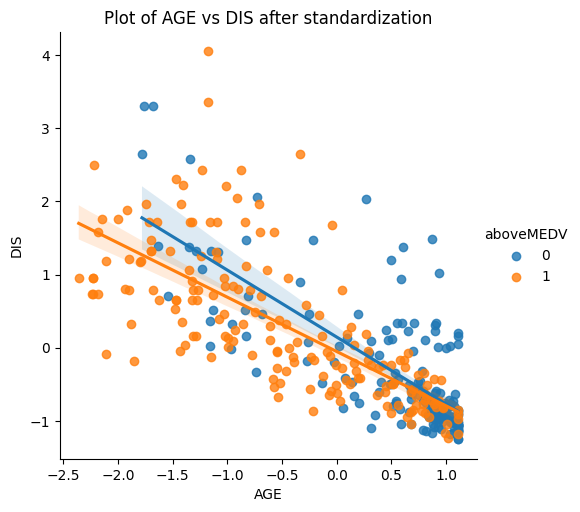

In [4]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

train_df = X_train.copy()
train_df['aboveMEDV'] = y_train

sns.lmplot(x='AGE', y='DIS', hue='aboveMEDV', data=train_df)
plt.title('Plot of AGE vs DIS')
plt.show()

# Standardizing two features
scaler = StandardScaler()
train_df[['AGE', 'DIS']] = scaler.fit_transform(train_df[['AGE', 'DIS']])

# Plotting after standardization
sns.lmplot(x='AGE', y='DIS', hue='aboveMEDV', data=train_df)
plt.title('Plot of AGE vs DIS after standardization')
plt.show()

1. The distribution of the datapoints are similar on both plots because standardization doesn't change the relative distances between datapoints but the scale on the x&y axis.
2. One biggest advantage of standardizing the datapoints is that it brings all the features to a common scale. It sometimes will save computational power in calculating distances that span into a larger scale or higher dimensions, especially in the KNN algorithm below.

## Part 2: KNN Classifier without Standardization [2 Marks]
Normally, standardizing data is a key step in preparing data for a KNN classifier. However, for educational purposes, let's first try to build a model without standardization. Let's create a KNN classifier to predict whether a house has the owner-occupied homes value that is less than the median or greater than the median.

Follow these steps:

1.   Train a KNN Classifier using cross-validation on the dataset. Sweep `k` (number of neighbours) from 1 to 100, and show a plot of the mean cross-validation accuracy vs `k`. **[1]**
2.   What is the best `k`? What is the highest cross-validation accuracy? **[0.5]**
3. Comment on  which ranges of `k` lead to underfitted or overfitted models (hint: compare training and validation curves!). **[0.5]**



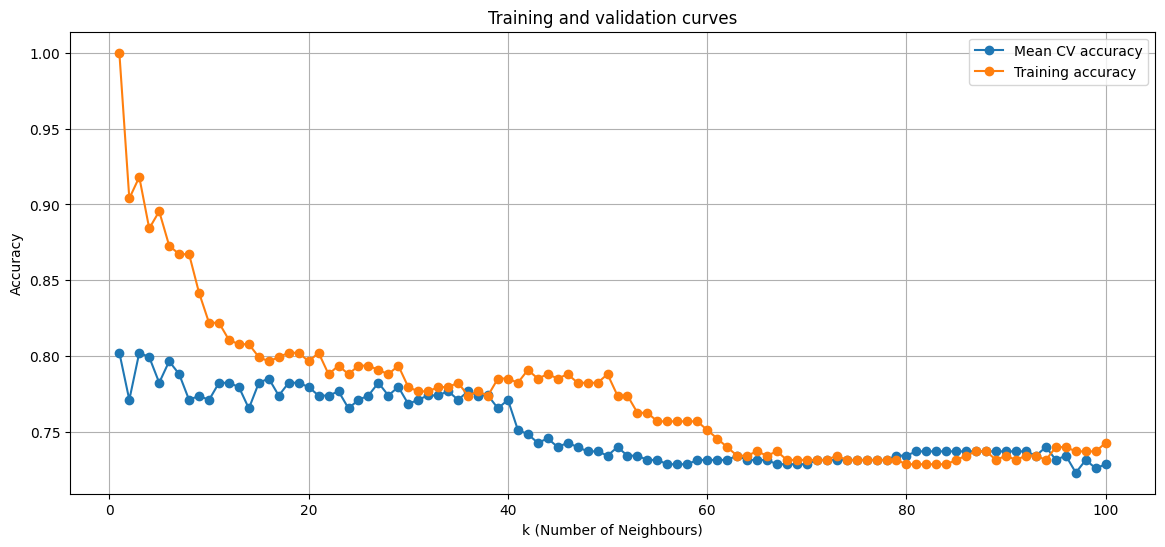

(1, 0.8023340040241449)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_values = range(1, 101)
mean_cv_accuracies = []
training_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
    mean_cv_accuracies.append(cv_scores.mean())

    knn.fit(X_train, y_train)
    training_accuracies.append(knn.score(X_train, y_train))

plt.figure(figsize=(14, 6))
plt.plot(k_values, mean_cv_accuracies, label='Mean CV accuracy', marker='o')
plt.plot(k_values, training_accuracies, label='Training accuracy', marker='o')
plt.xlabel('k (Number of Neighbours)')
plt.ylabel('Accuracy')
plt.title('Training and validation curves')
plt.legend()
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(mean_cv_accuracies)]
highest_cv_accuracy = max(mean_cv_accuracies)

best_k, highest_cv_accuracy

1. For very low values in $ k (1 \leq k \leq 9)$, the model is likely to be sensitive to noise in the training data, making it overfit.
2. For high values in $ k (k >60)$, The mean CV accuracy starts to decrease, and the model begins to underperform. This is a sign of underfitting, as the model becomes too simple to capture the underlying trends in the data.

## Part 3: Feature Selection [3 Marks]
In this part, we aim to investigate the importance of each feature on the final classification accuracy.
If we want to try every possible combination of features, we would have to test  $2^F$ different cases,  where F is the number of features, and in each case, we have to do a hyperparameter search (finding K, in KNN using cross-validation). That will take days!.

To find more important features we will use a decision tree. based on a decision tree we can compute feature importance that is a metric for our feature selection (code is provided below).

You can use [this link](https://machinelearningmastery.com/calculate-feature-importance-with-python/
) to get familiar with extracting the feature impotance order of machine learning algorithms in Python.

After we identified and removed the least important feature and evaluated a new KNN model on the new set of features, if the stop conditions (see step 7 below) are not met, we need to repeat the process and remove another feature.


Design a function ( `Feature_selector`) that accepts your dataset (X_train , y_train) and a threshold as inputs and: **[1]**
1. Fits a decision tree classifier on the training set.

2. Extracts the feature importance order of the decision tree model.

3. Removes the least important feature based on step 2.
4. Then, a KNN model is trained on the remaining features. The number of neighbors (`k`) for each KNN model should be tuned using a 5-fold cross-validation.
5. Store the best `mean cross-validation` score and the corresponding `k` (number of neighbours) value in two lists.
6. Go back to step 3 and follow all the steps until you meet the stop condition (step 7).

7. We will stop this process when (1) there is only one feature left, or (2) our cross-validation accuracy is dropped significantly compared to a model that uses all the features. In this function, we accept a threshold as an input argument. For example, if threshold=0.95 we do not continue removing features if our mean cross-validation accuracy after tuning `k` is bellow **0.95 $\times$ Full Feature cross-validation accuracy**.

8. Your function returns the list of removed features, and the corresponding mean cross-validation accuracy and `k` value when a feature was removed.

* Visualize your results by plotting the mean cross-validation accuracy (with a tuned `k` on y axis) vs. the on the number of features (x axis). This plot describes: what is the best cv score with 1 feature, 2 features, 3 features ... and all the features. **[0.5]**

* Plot the best value of `k` (y-axis) vs. the number of features. This plot explains the trend of number of neighbours with respect to the number of features.  **[0.5]**

* State what is the number of essential features for classification and justify your answer. **[1]**
  
  









You can use the following piece of code to start training a decision tree classifier and obtain its feature importance order.
```
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_train,y_train)
importance = dt.feature_importances_
```


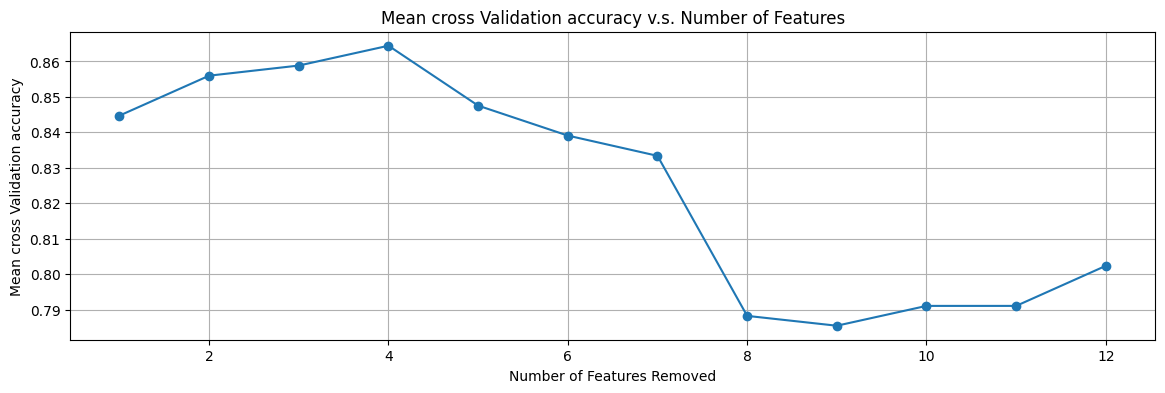

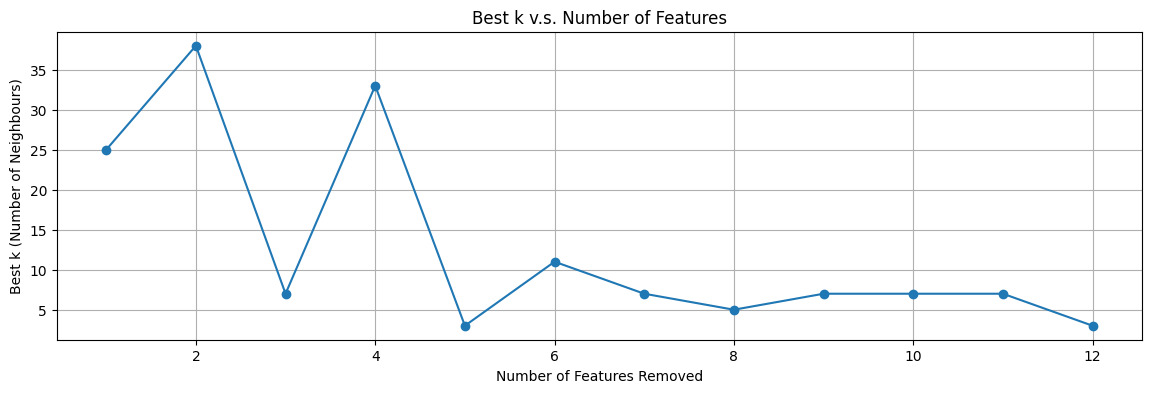

In [22]:
from sklearn.tree import DecisionTreeClassifier

def Feature_selector (X_train , y_train , tr=0.95):
    removed_features = []
    cv_accuracies = []
    best_ks = []

    full_feature_knn = KNeighborsClassifier()
    full_feature_cv_score = np.mean(cross_val_score(full_feature_knn, X_train, y_train, cv=5))

    while len(X_train.columns) > 1:
        dt = DecisionTreeClassifier(random_state=0)
        dt.fit(X_train, y_train)

        feature_importances = dt.feature_importances_
        least_important_idx = np.argmin(feature_importances)
        least_important_feature = X_train.columns[least_important_idx]

        X_train = X_train.drop(columns=[least_important_feature])
        removed_features.append(least_important_feature)

        k_values = range(1, 101)
        cv_scores = []
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k)
            cv_score = np.mean(cross_val_score(knn, X_train, y_train, cv=5))
            cv_scores.append(cv_score)

        best_k = k_values[np.argmax(cv_scores)]
        best_cv_score = np.max(cv_scores)
        best_ks.append(best_k)
        cv_accuracies.append(best_cv_score)

        if best_cv_score < tr * full_feature_cv_score:
            break

    return removed_features, cv_accuracies, best_ks

removed_features, cv_accuracies, best_ks = Feature_selector(X_train, y_train, tr=0.95)
removed_features, cv_accuracies, best_ks

# Plotting mean cross-validation accuracy vs number of features
plt.figure(figsize=(14, 4))
plt.plot(np.arange(len(cv_accuracies), 0, -1), cv_accuracies, marker='o')
plt.xlabel('Number of Features Removed')
plt.ylabel('Mean cross Validation accuracy')
plt.title('Mean cross Validation accuracy v.s. Number of Features')
plt.grid(True)
plt.show()

# Plotting best k vs number of features
plt.figure(figsize=(14, 4))
plt.plot(np.arange(len(best_ks), 0, -1), best_ks, marker='o')
plt.xlabel('Number of Features Removed')
plt.ylabel('Best k (Number of Neighbours)')
plt.title('Best k v.s. Number of Features')
plt.grid(True)
plt.show()

The number of essential features for classification appears to be around 9 to 10 features. This conclusion is justified by observing the peak in mean cross-validation accuracy when approximately 3 to 4 features have been removed from the original 13. After reaching the peak, the accuracy starts to decline as more features are removed. This suggests that further removals start to eliminate essential features, negatively impacting the model's performance.

## Part 4: Standardization [1 Marks]

Standardizing the data usually means scaling our data to have a mean of zero and a standard deviation of one.

**Note:** When we standardize a dataset, do we care if the data points are in our training set or test set? Yes! The training set is available for us to train a model - we can use it however we want. The test set, however, represents a subset of data that is not available for us during training. For example, the test set can represent the data that someone who bought our model would use to see how the model performs (which they are not willing to share with us).
Therefore, we cannot compute the mean or standard deviation of the whole dataset to standardize it - we can only calculate the mean and standard deviation of the training set. However, when we sell a model to someone, we can say what our scalers (mean and standard deviation of our training set) was. They can scale their data (test set) with our training set's mean and standard deviation. Of course, there is no guarantee that the test set would have a mean of zero and a standard deviation of one, but it should work fine.

**To summarize: We fit the StandardScaler only on the training set. We transform both training and test sets with that scaler.**

1. Standardize the training  and test data ([Help](https://scikit-learn.org/stable/modules/preprocessing.html))

2. Call your ``Feature_selector`` function on the standardized training data with a threshold of 95\%.
 * Plot the Cross validation accuracy when we have the standardized data (this part) and the original training data (last part) vs. the Number of features in a single plot (to compare them easily).

3. Discuss how standardization affected your model and its performance?


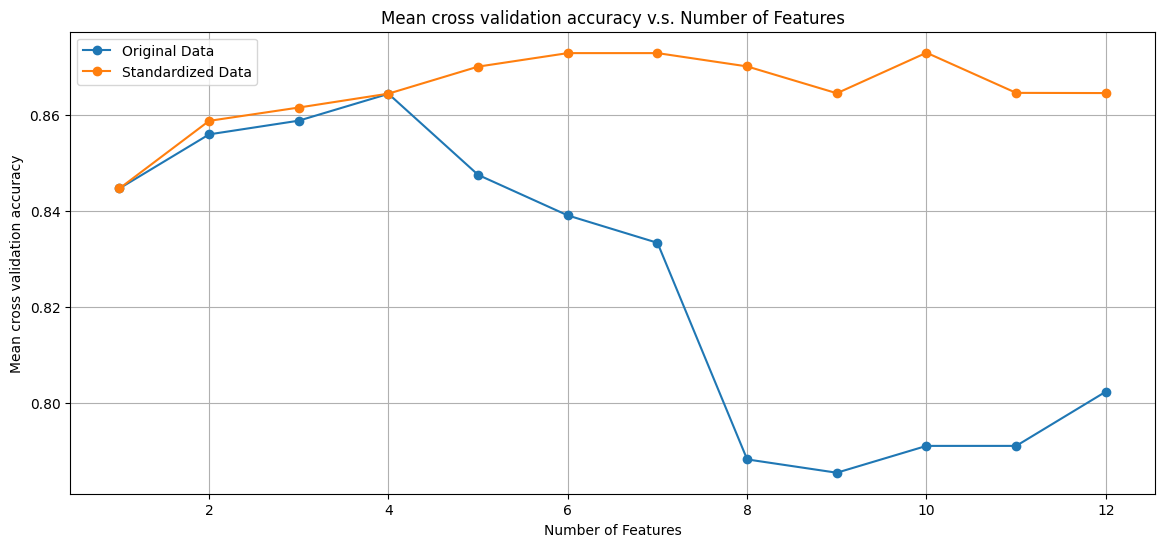

In [23]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
removed_features_scaled, cv_accuracies_scaled, best_ks_scaled = Feature_selector(X_train_scaled_df, y_train, tr = 0.95)

plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(cv_accuracies), 0, -1), cv_accuracies, marker='o', label='Original Data')
plt.plot(np.arange(len(cv_accuracies_scaled), 0, -1), cv_accuracies_scaled, marker='o', label='Standardized Data')
plt.xlabel('Number of Features')
plt.ylabel('Mean cross validation accuracy')
plt.title('Mean cross validation accuracy v.s. Number of Features')
plt.legend()
plt.grid(True)
plt.show()


1.Standardization generally improves the performance of the KNN classifier, as we can see from the higher cross validation accuracy line for the standardized data. And the standardized data maintained good performance even as features were removed, showing that standardization can make the model more robust. This is critical as KNN is a distance-based algo that is very sensitive to the scale of the datapoints.

## Part 5: Decision Tree Classifier [1 Mark]

Train a decision tree classifier on the standardized dataset (read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and check the example there.) Tune the `max_depth` and `min_samples_split` parameters of the tree using cross-validation (CV).
 * Compare the decision tree's performance (mean CV score) with KNN, both using all the features.


In [ ]:
from sklearn.model_selection import GridSearchCV
dt = DecisionTreeClassifier(random_state=0)

param_grid = {
    'max_depth': list(range(1, 11)),
    'min_samples_split': list(range(2, 100))}

grid_search_dt = GridSearchCV(dt, param_grid, cv=5)
grid_search_dt.fit(X_train_scaled_df, y_train)

# Best parameters and corresponding mean CV score for Decision Tree
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

k_values = range(1, 101)
cv_scores_knn = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_score = np.mean(cross_val_score(knn, X_train_scaled_df, y_train, cv=5))
    cv_scores_knn.append(cv_score)

best_score_knn = max(cv_scores_knn)
best_params_dt, best_score_dt, best_score_knn

({'max_depth': 3, 'min_samples_split': 2},
 0.8503018108651912,
 0.8758148893360161)

Both classifiers perform similarly on the dataset when using all features. The Decision Tree has a slightly higher mean cross-validation score of 0.876 compared to the KNN's 0.873.


## Part 6: Test Data [0.5 Mark]

Now that you've created several models, pick your best one (highest CV accuracy) and apply it to the test dataset you had initially set aside. Discuss your results.

In [ ]:
best_dt = DecisionTreeClassifier(max_depth=3, min_samples_split=2, random_state=0)
best_dt.fit(X_train_scaled_df, y_train)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

test_score_dt = best_dt.score(X_test_scaled_df, y_test)
test_score_dt

0.7763157894736842

Decision Tree (with standardization): Mean CV Accuracy ≈ 87.6% <- The best

KNN (with standardization): Mean CV Accuracy ≈ 87.3%

KNN (without standardization): Mean CV Accuracy ≈ 80.5%

The test accuracy for our chosen Decision Tree model with a max_depth of 3 and min_samples_split of 2 is approximately 77.6%. This performance is slightly lower than the cross-validation accuracy of 87.6% we got from fine-tuning in part 4. The difference suggests a degree of overfitting to the training data, but it is still a reasonable outcome. It means that our model generalizes fairly well to unseen data, even though there may be room for further optimization.